In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, add
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, normalize
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from IPython.display import display
import skimage.io
from skimage import io
import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from IPython.display import display
! pip install -q kaggle

from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

! kaggle datasets download mateuszbuda/lgg-mri-segmentation

Saving kaggle.json to kaggle.json
ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           9371        278  1.0              
mattop/alcohol-consumption-per-capita-2016                      Alcohol Consumption Per Capita 2016                   4KB  2022-12-09 00:03:11            957         33  1.0              
michals22/coffee-dataset                                        Coffee dataset                                       24KB  2022-12-15 20:02:12           1018         36  1.0              
thedevastator/jobs-dataset

In [ ]:
!mkdir -p dataset && cd dataset && unzip /content/car-object-detection.zip
! unzip '/content/lgg-mri-segmentation.zip'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA

In [ ]:
from tqdm import tqdm
import cv2

root = '/content/lgg-mri-segmentation/kaggle_3m'

# os.listdir(root)
#Reading 

def get_images_path():
    images = []
    labels = []
    for d in tqdm(os.listdir(root)):
        path = os.path.join(root, d)
        if os.path.isdir(path):
            iters = int(len(os.listdir(path))/2)
            for i in range(iters): 
                file = os.path.join(path, d) + '_' +str(i+1) + '.tif'
                mask = os.path.join(path, d) + '_' +str(i+1) + '_mask.tif'
                images.append(file)
                labels.append(mask)
    return images, labels
imgs, labels = get_images_path()

100%|██████████| 112/112 [00:00<00:00, 4713.03it/s]


In [ ]:
img_height=256
img_width=256

In [ ]:
df=pd.DataFrame(data={'img_path':imgs,'mask_path':labels})
df.shape

(3929, 2)

In [ ]:
# Check whether mask is present or not
def check_mask(mask_path):
    img = cv2.imread(mask_path)
    max_val = img.max()
    if max_val > 0:
        return 1
    else:
        return 0

In [ ]:
# Creating a new 'mask' column which shows if mask is present or not
df['mask'] = df['mask_path'].apply(lambda x: check_mask(x))
df

,img_path,mask_path,mask
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
...,...,...,...
3924,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3925,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3926,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3927,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0


In [ ]:
df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

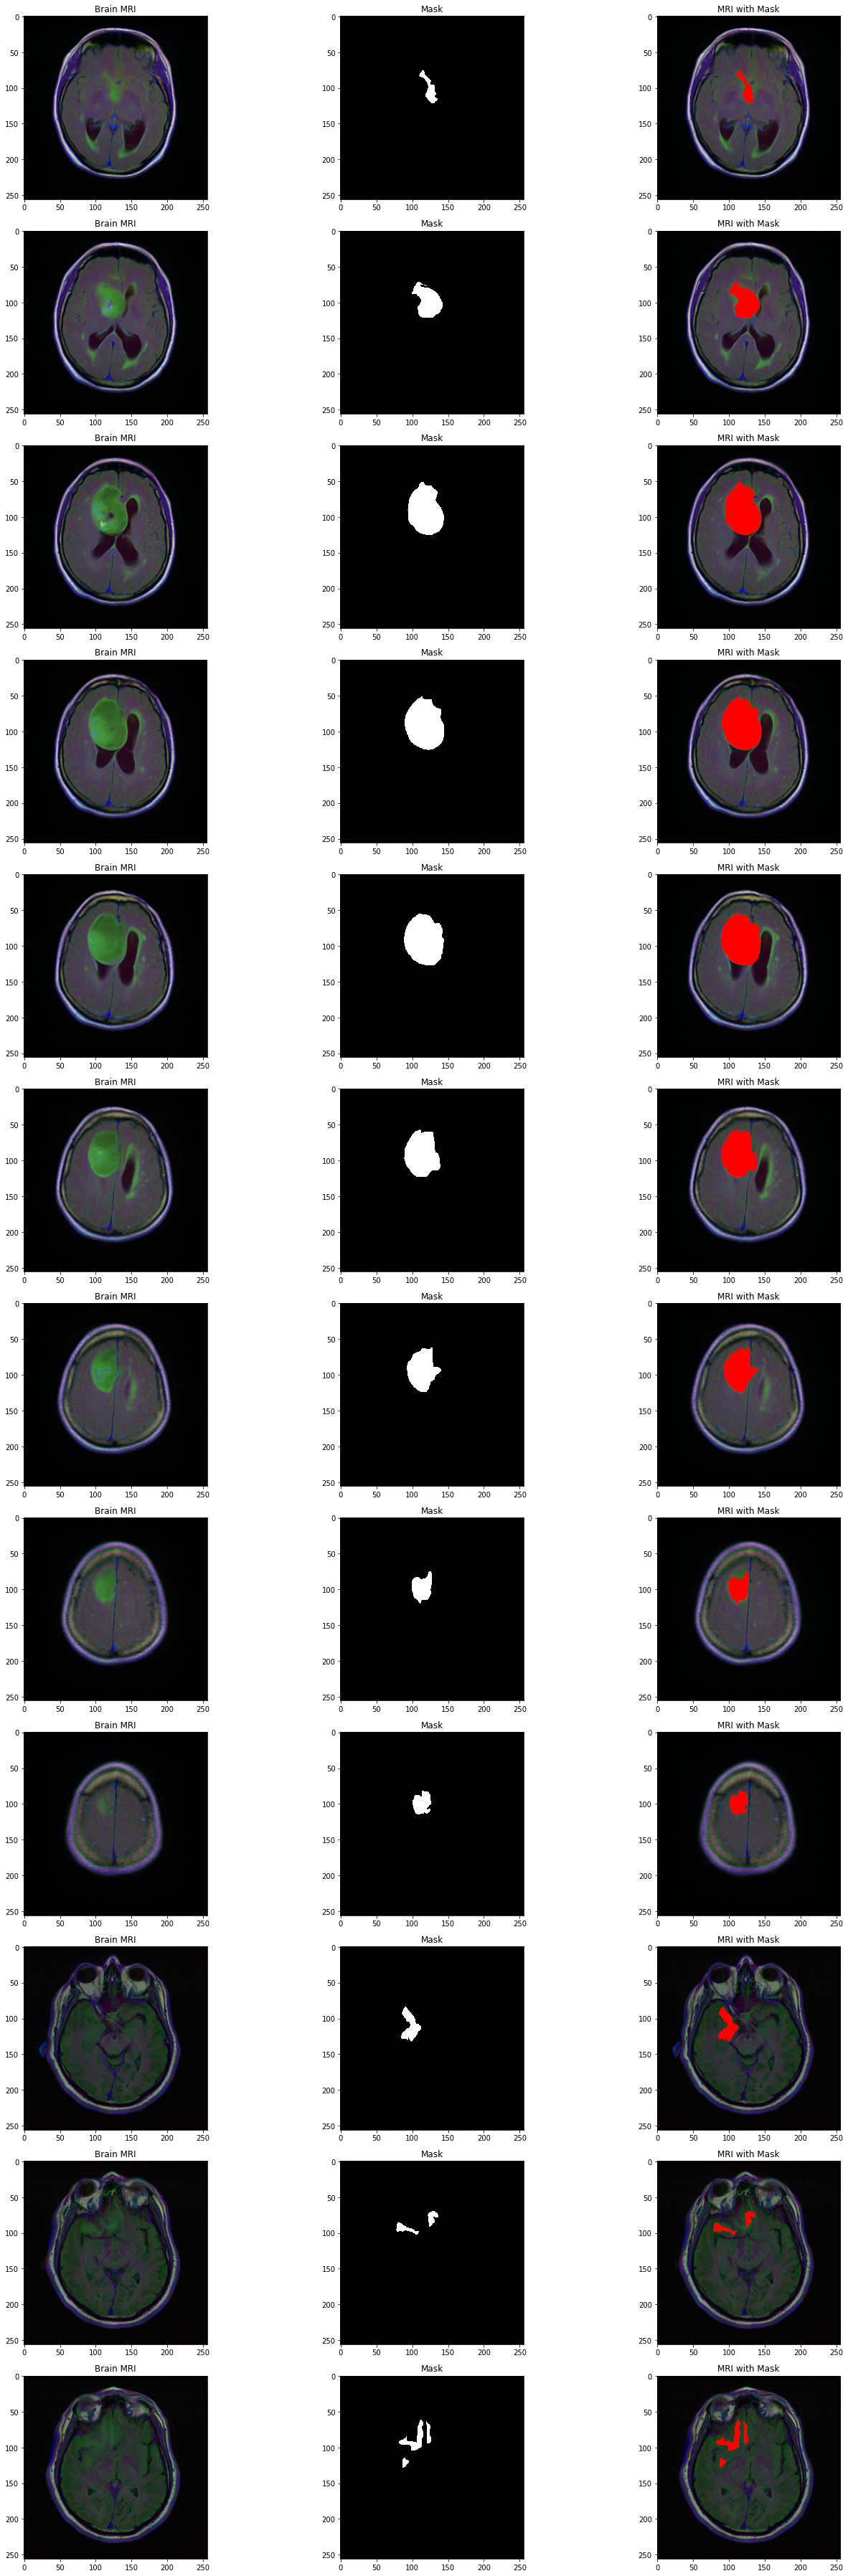

In [ ]:
from skimage import io
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in df['mask']:
    if (mask==1):
        img = io.imread(df.img_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

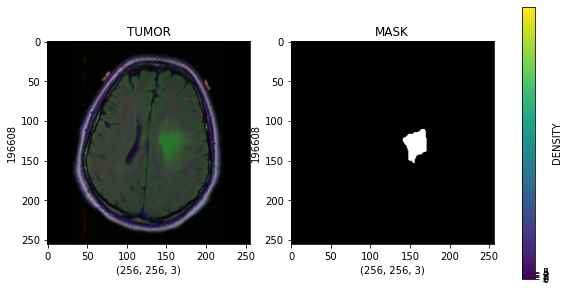

In [ ]:
Example_Image_ONE = '/content/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_13.tif'
Example_Mask_ONE = "/content/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_13_mask.tif"

figure,axis = plt.subplots(1,2,figsize=(10,10))

Example_Reading_Image = cv2.cvtColor(cv2.imread(Example_Image_ONE),cv2.COLOR_BGR2RGB)
Example_Reading_Mask = cv2.cvtColor(cv2.imread(Example_Mask_ONE),cv2.COLOR_BGR2RGB)

axis[0].set_xlabel(Example_Reading_Image.shape)
axis[0].set_ylabel(Example_Reading_Image.size)
axis[0].set_title("TUMOR")
Example_Colorbar_Plt = axis[0].imshow(Example_Reading_Image)

axis[1].set_xlabel(Example_Reading_Mask.shape)
axis[1].set_ylabel(Example_Reading_Mask.size)
axis[1].set_title("MASK")
axis[1].imshow(Example_Reading_Mask)

figure.colorbar(Example_Colorbar_Plt,
                ax=axis.ravel().tolist(),
                shrink=0.5,
                ticks=range(6),
                label='DENSITY')

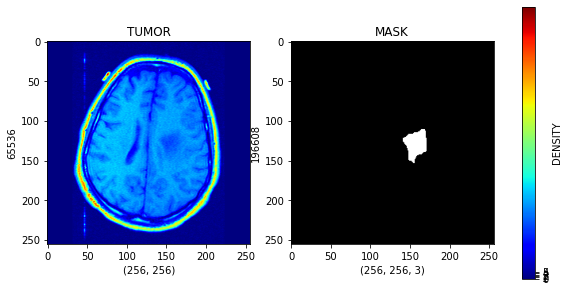

In [ ]:
figure,axis = plt.subplots(1,2,figsize=(10,10))

Example_Reading_Image = cv2.cvtColor(cv2.imread(Example_Image_ONE),cv2.COLOR_BGR2RGB)
Example_Reading_Mask = cv2.cvtColor(cv2.imread(Example_Mask_ONE),cv2.COLOR_BGR2RGB)

axis[0].set_xlabel(Example_Reading_Image[:,:,0].shape)
axis[0].set_ylabel(Example_Reading_Image[:,:,0].size)
axis[0].set_title("TUMOR")
Example_Colorbar_Plt = axis[0].imshow(Example_Reading_Image[:,:,0],cmap="jet")

axis[1].set_xlabel(Example_Reading_Mask.shape)
axis[1].set_ylabel(Example_Reading_Mask.size)
axis[1].set_title("MASK")
axis[1].imshow(Example_Reading_Mask)

figure.colorbar(Example_Colorbar_Plt,
                ax=axis.ravel().tolist(),
                shrink=0.5,
                ticks=range(6),
                label='DENSITY')

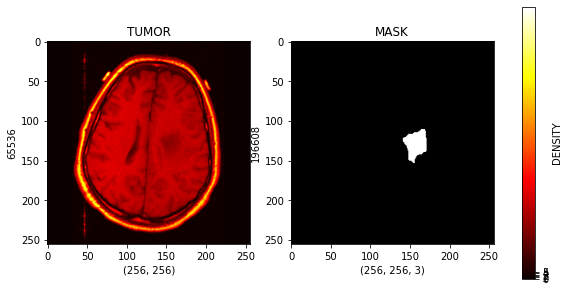

In [ ]:
figure,axis = plt.subplots(1,2,figsize=(10,10))

Example_Reading_Image = cv2.cvtColor(cv2.imread(Example_Image_ONE),cv2.COLOR_BGR2RGB)
Example_Reading_Mask = cv2.cvtColor(cv2.imread(Example_Mask_ONE),cv2.COLOR_BGR2RGB)

axis[0].set_xlabel(Example_Reading_Image[:,:,0].shape)
axis[0].set_ylabel(Example_Reading_Image[:,:,0].size)
axis[0].set_title("TUMOR")
Example_Colorbar_Plt = axis[0].imshow(Example_Reading_Image[:,:,0],cmap="hot")

axis[1].set_xlabel(Example_Reading_Mask.shape)
axis[1].set_ylabel(Example_Reading_Mask.size)
axis[1].set_title("MASK")
axis[1].imshow(Example_Reading_Mask)

figure.colorbar(Example_Colorbar_Plt,
                ax=axis.ravel().tolist(),
                shrink=0.5,
                ticks=range(6),
                label='DENSITY')

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=2)
# validation split
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=2)
print("Train shape: {}\nTest shape: {}\nValidation shape: {}".format(df_train.shape, df_test.shape, df_val.shape))

Train shape: (2828, 3)
Test shape: (393, 3)
Validation shape: (708, 3)


In [ ]:
# normalising and setting mask threshold
def normalise_and_set_threshold(image, mask):
    image = image/255
    mask = mask/255
    mask[mask>0.5] = 1
    mask[mask<=0.5] = 0
    return (image, mask)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_generator(dataframe, batch_size, augmentation_dict, target_size = (256,256), image_color_mode='rgb', 
                    mask_color_mode='grayscale', image_save_prefix='image', mask_save_prefix='mask',
                   save_to_dir= None, seed=2):
    
    # ImageDataGenerator generate batches of tensor image data with real-time data augmentation.
    image_data_generator = ImageDataGenerator(**augmentation_dict)
    mask_data_generator = ImageDataGenerator(**augmentation_dict)
    
    image_generator = image_data_generator.flow_from_dataframe(dataframe=dataframe,
                                                              x_col = 'img_path',
                                                              target_size=target_size,
                                                              color_mode = image_color_mode,
                                                              class_mode=None,  # modes for yielding the target, None means no targets returned
                                                              batch_size=batch_size,
                                                              seed=seed,
                                                              save_to_dir=save_to_dir,
                                                              save_prefix=image_save_prefix)
    mask_generator = mask_data_generator.flow_from_dataframe(dataframe = dataframe,
                                                            x_col= 'mask_path',
                                                            target_size = target_size,
                                                            color_mode = mask_color_mode,
                                                            class_mode = None,
                                                            batch_size = batch_size,
                                                            seed = seed,
                                                            save_to_dir= save_to_dir,
                                                            save_prefix= mask_save_prefix)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = normalise_and_set_threshold(img, mask)
        yield (img, mask)

In [ ]:
def dice_coeff(ytrue, ypred, smooth=100):
    ytrue_flat = K.flatten(ytrue)
    ypred_flat = K.flatten(ypred)
    
    intersection = K.sum(ytrue_flat * ypred_flat)
    total_area = K.sum(ytrue_flat) + K.sum(ypred_flat)
    return (2*intersection + smooth)/(total_area + smooth)

def dice_coeff_loss(ytrue,ypred, smooth=100):
    return 1-dice_coeff(ytrue, ypred, smooth)

def iou_coeff(ytrue, ypred, smooth=100):
    intersection = K.sum(ytrue * ypred)
    union = K.sum(ytrue + ypred) - intersection
    return (intersection + smooth)/(union + smooth)

def jaccard_distance(ytrue, ypred):
    ytrue_flat = K.flatten(ytrue)
    ypred_flat = K.flatten(ypred)
    return 1-iou_coeff(ytrue_flat, ypred_flat)

In [ ]:
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, MaxPooling2D, 
                                     Dropout, Activation, BatchNormalization, concatenate)
from tensorflow.keras.models import Model, load_model, save_model

def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

def ResUnet(input):
  X_input = Input(input) #iniating tensor of input shape

  # Stage 1
  conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
  conv_1 = BatchNormalization()(conv_1)
  conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
  conv_1 = BatchNormalization()(conv_1)
  pool_1 = MaxPool2D((2,2))(conv_1)

  # stage 2
  conv_2 = resblock(pool_1, 32)
  pool_2 = MaxPool2D((2,2))(conv_2)

  # Stage 3
  conv_3 = resblock(pool_2, 64)
  pool_3 = MaxPool2D((2,2))(conv_3)

  # Stage 4
  conv_4 = resblock(pool_3, 128)
  pool_4 = MaxPool2D((2,2))(conv_4)

  # Stage 5 (bottle neck)
  conv_5 = resblock(pool_4, 256)

  # Upsample Stage 1
  up_1 = upsample_concat(conv_5, conv_4)
  up_1 = resblock(up_1, 128)

  # Upsample Stage 2
  up_2 = upsample_concat(up_1, conv_3)
  up_2 = resblock(up_2, 64)

  # Upsample Stage 3
  up_3 = upsample_concat(up_2, conv_2)
  up_3 = resblock(up_3, 32)

  # Upsample Stage 4
  up_4 = upsample_concat(up_3, conv_1)
  up_4 = resblock(up_4, 16)

  # final output
  out= Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

  model= Model(X_input,out, name="Res_U-Net")
  
  return model

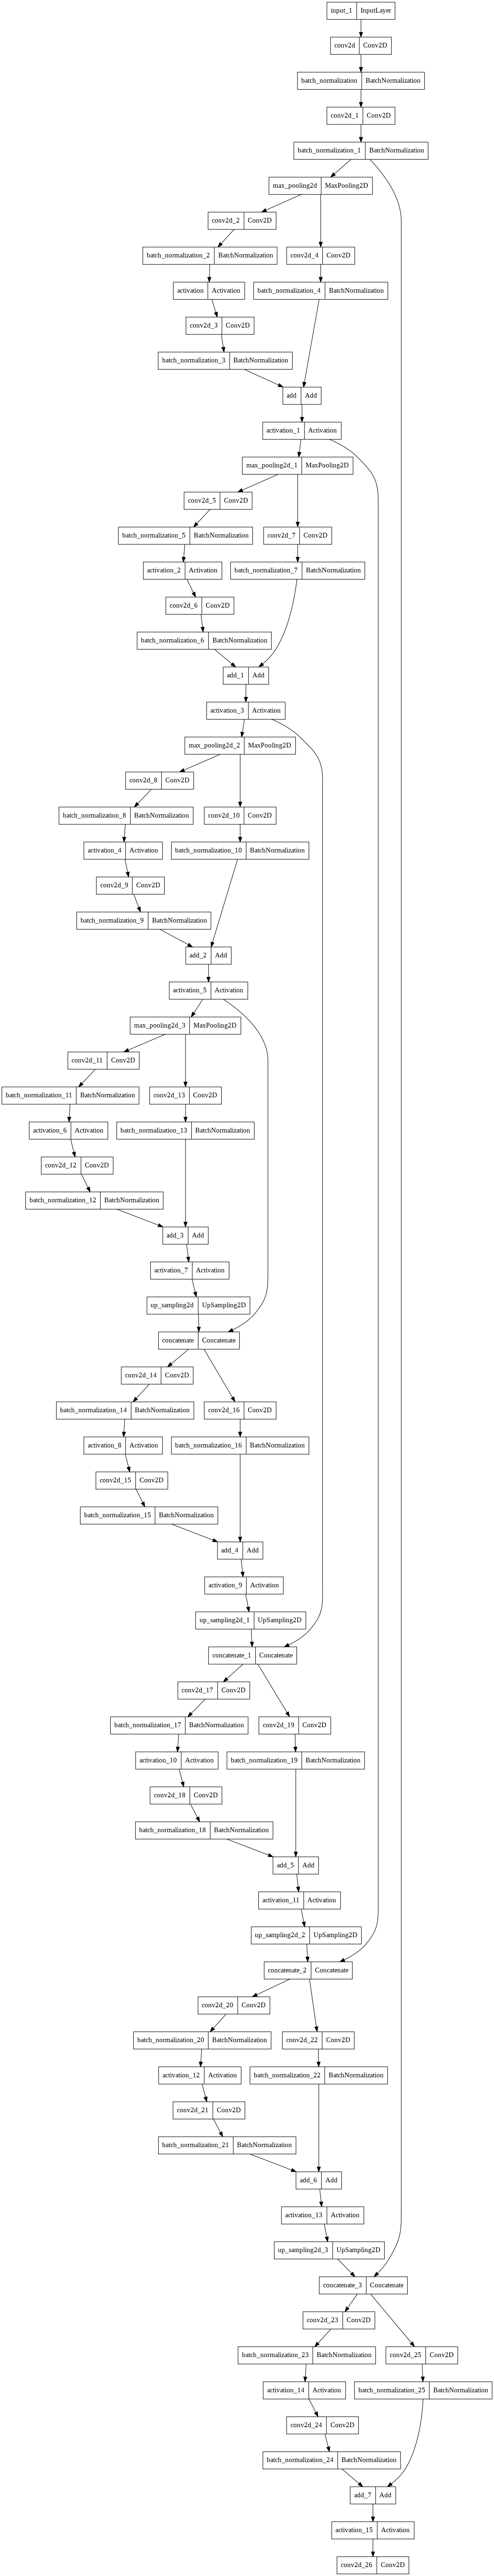

In [ ]:
model = ResUnet((256,256,3))

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

In [ ]:
model.summary()

Model: "Res_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                         

In [ ]:
augmentation_dict = dict(rotation_range=0.1,
                        width_shift_range = 0.05,
                        height_shift_range = 0.05,
                        brightness_range = (0.2,1.3),
                        shear_range = 0.1,
                        zoom_range = 0.1,
                        horizontal_flip = True,
                        vertical_flip = True,
                        fill_mode = 'nearest')

batch_size = 64
epochs = 64
learning_rate = 1e-3

train_gen = train_generator(df_train, batch_size, augmentation_dict, target_size = (img_height, img_width))
val_gen = train_generator(df_val, batch_size, dict(), target_size=(img_height, img_width))

In [ ]:
# setting our optimizer and compiling
decay_rate = learning_rate/epochs

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999,
                                    epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=optimizer, loss=dice_coeff_loss, metrics=['binary_accuracy',dice_coeff, iou_coeff])

model.summary()

Model: "Res_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                         

In [ ]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=25, monitor='val_dice_coeff', 
                                                 mode = 'max', restore_best_weights=True),
                tf.keras.callbacks.ModelCheckpoint('mri_seg_unet.hdf5', verbose=1, 
                                                   save_best_only=True),
                tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [ ]:
steps_per_epoch = len(df_train)/batch_size
val_steps = len(df_val)/batch_size

history = model.fit(train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=[my_callbacks], 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/64
45/44 [==============================] - ETA: -1s - loss: 0.5798 - binary_accuracy: 0.9935 - dice_coeff: 0.4237 - iou_coeff: 0.2729
Epoch 1: val_loss did not improve from 0.97623
44/44 [==============================] - 70s 2s/step - loss: 0.5798 - binary_accuracy: 0.9935 - dice_coeff: 0.4237 - iou_coeff: 0.2729 - val_loss: 0.9782 - val_binary_accuracy: 0.1365 - val_dice_coeff: 0.0249 - val_iou_coeff: 0.0127
Epoch 2/64
45/44 [==============================] - ETA: -1s - loss: 0.4216 - binary_accuracy: 0.9945 - dice_coeff: 0.5788 - iou_coeff: 0.4148
Epoch 2: val_loss improved from 0.97623 to 0.92546, saving model to mri_seg_unet.hdf5
44/44 [==============================] - 66s 2s/step - loss: 0.4216 - binary_accuracy: 0.9945 - dice_coeff: 0.5788 - iou_coeff: 0.4148 - val_loss: 0.9255 - val_binary_accuracy: 0.8642 - val_dice_coeff: 0.0793 - val_iou_coeff: 0.0416
Epoch 3/64
45/44 [==============================] - ETA: -1s - loss: 0.3844 - binary_accuracy: 0.9950 - dice_coeff:

KeyboardInterrupt: ignored

In [ ]:
df_test[df_test['mask']==1].values[0]

'/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_17.tif'

In [ ]:
img = cv2.imread('/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_17.tif')
img = cv2.resize(img, (img_height, img_width))
img = img/255
# print(img.shape) (256, 256 , 3)
img = img[np.newaxis, :, :, : ]
# print(img.shape) # (1, 256, 256, 3)

predicted_img = model.predict(img)

1/1 [==============================] - 0s 18ms/step


In [ ]:
predicted_img.shape

(1, 256, 256, 1)

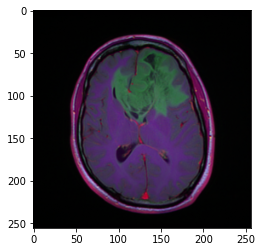

In [ ]:
plt.imshow(np.squeeze(img))

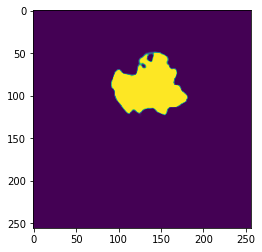

In [ ]:
plt.imshow(np.squeeze(predicted_img))

1/1 [==============================] - 0s 33ms/step


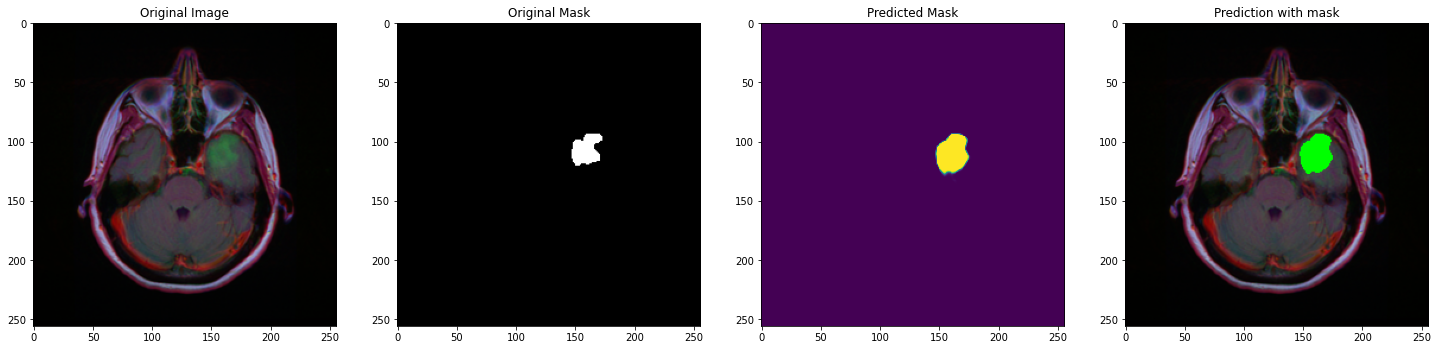

In [ ]:
def figures(idx,color=(255,0,0)):

  img = cv2.imread(df_test[df_test['mask']==1].values[idx][0])
  img = cv2.resize(img, (img_height, img_width))
  img = img/255
  # print(img.shape) (256, 256 , 3)
  img = img[np.newaxis, :, :, : ]
  # print(img.shape) # (1, 256, 256, 3)

  predicted_img = model.predict(img)

  # original image
  plt.figure(figsize=(25,25))
  plt.subplot(1, 4, 1)
  im=np.squeeze(img)
  plt.imshow(np.squeeze(img))
  plt.title('Original Image')

  plt.subplot(1, 4, 2)
  plt.imshow(np.squeeze(cv2.imread(df_test[df_test['mask']==1].values[idx][1])))
  plt.title('Original Mask')

  plt.subplot(1, 4, 3)
  pred=np.squeeze(predicted_img)
  plt.imshow(pred)
  plt.title('Predicted Mask')

  plt.subplot(1, 4, 4)
  im[pred>0.5]=color
  plt.imshow(np.squeeze(im))
  plt.title('Prediction with mask')
figures(20,(0,255,0))